In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score

In [30]:
data = pd.read_csv("Airline_Delay_Cause.csv")
data.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",89.0,13.0,2.25,1.60,...,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",62.0,10.0,1.97,0.04,...,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,10.0,2.73,1.18,...,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",66.0,12.0,3.69,2.27,...,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",92.0,22.0,7.76,0.00,...,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


In [31]:
holiday_months = [7, 8, 11, 12]
top_carriers = ['AS', 'DL', 'AA', 'UA', 'B6', 'WN']

data['holiday'] = data['month'].apply(lambda x: 'holiday' if x in holiday_months else 'non_holiday')
data['carrier_category'] = data['carrier'].apply(lambda x: 'top' if x in top_carriers else 'non_top')

predictors = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_flights']
target = 'arr_del15'

filtered_data = data.dropna(subset = predictors + [target])

holiday_top = filtered_data[(filtered_data['holiday'] == 'holiday') & (filtered_data['carrier_category'] == 'top')]
non_holiday_top = filtered_data[(filtered_data['holiday'] == 'non_holiday') & (filtered_data['carrier_category'] == 'top')]
holiday_non_top = filtered_data[(filtered_data['holiday'] == 'holiday') & (filtered_data['carrier_category'] == 'non_top')]
non_holiday_non_top = filtered_data[(filtered_data['holiday'] == 'non_holiday') & (filtered_data['carrier_category'] == 'non_top')]

def train_rf_model(data, predictors, target, perform_cv=False, cv_folds=5):
    X = data[predictors]
    y = (data[target] > 0).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    rf_model = RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        class_weight='balanced'
    )
    rf_model.fit(X_train, y_train)
    
    y_predict = rf_model.predict(X_test)
    report = classification_report(y_test, y_predict, output_dict=True)
    accuracy = accuracy_score(y_test, y_predict)
    
    feature_importances = pd.DataFrame({
        'feature': predictors,
        'importance': rf_model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    if perform_cv:
        cv_scores = cross_val_score(rf_model, X, y, cv=cv_folds, scoring='accuracy')
        cv_mean_accuracy = cv_scores.mean()
        return report, feature_importances, accuracy, cv_scores, cv_mean_accuracy, rf_model
    else:
        return report, feature_importances, accuracy, rf_model

holiday_top_report, holiday_top_importances, holiday_top_accuracy, holiday_top_cv_scores, holiday_top_cv_mean, holiday_top_model = train_rf_model(holiday_top, predictors, target, perform_cv=True)
non_holiday_top_report, non_holiday_top_importances, non_holiday_top_accuracy, non_holiday_top_cv_scores, non_holiday_top_cv_mean, non_holiday_top_model = train_rf_model(non_holiday_top, predictors, target, perform_cv=True)
holiday_non_top_report, holiday_non_top_importances, holiday_non_top_accuracy, holiday_non_top_cv_scores, holiday_non_top_cv_mean, holiday_non_top_model = train_rf_model(holiday_non_top, predictors, target, perform_cv=True)
non_holiday_non_top_report, non_holiday_non_top_importances, non_holiday_non_top_accuracy, non_holiday_non_top_cv_scores, non_holiday_non_top_cv_mean, non_holiday_non_top_model = train_rf_model(non_holiday_non_top, predictors, target, perform_cv=True)

cv_results = pd.DataFrame({
    "Model": [
        "Holiday & Top Airlines",
        "Non-Holiday & Top Airlines",
        "Holiday & Non-Top Airlines",
        "Non-Holiday & Non-Top Airlines"
    ],
    "Mean CV Accuracy": [
        holiday_top_cv_mean,
        non_holiday_top_cv_mean,
        holiday_non_top_cv_mean,
        non_holiday_non_top_cv_mean
    ],
    "CV Scores": [
        holiday_top_cv_scores.tolist(),
        non_holiday_top_cv_scores.tolist(),
        holiday_non_top_cv_scores.tolist(),
        non_holiday_non_top_cv_scores.tolist()
    ]
})

print("Cross-Validation Outcomes:")
print(cv_results.to_string(index=False))

Cross-Validation Outcomes:
                         Model  Mean CV Accuracy                                                            CV Scores
        Holiday & Top Airlines          1.000000                                            [1.0, 1.0, 1.0, 1.0, 1.0]
    Non-Holiday & Top Airlines          0.999909              [1.0, 0.9997728305315765, 1.0, 1.0, 0.9997728305315765]
    Holiday & Non-Top Airlines          0.999915              [1.0, 1.0, 0.9998582364615821, 1.0, 0.9997164327236637]
Non-Holiday & Non-Top Airlines          0.999884 [0.999927766541462, 0.999711066165848, 1.0, 0.9997832996243861, 1.0]


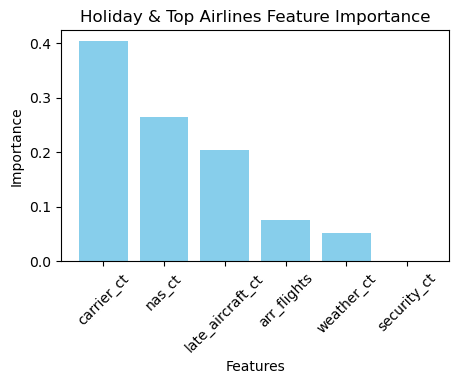

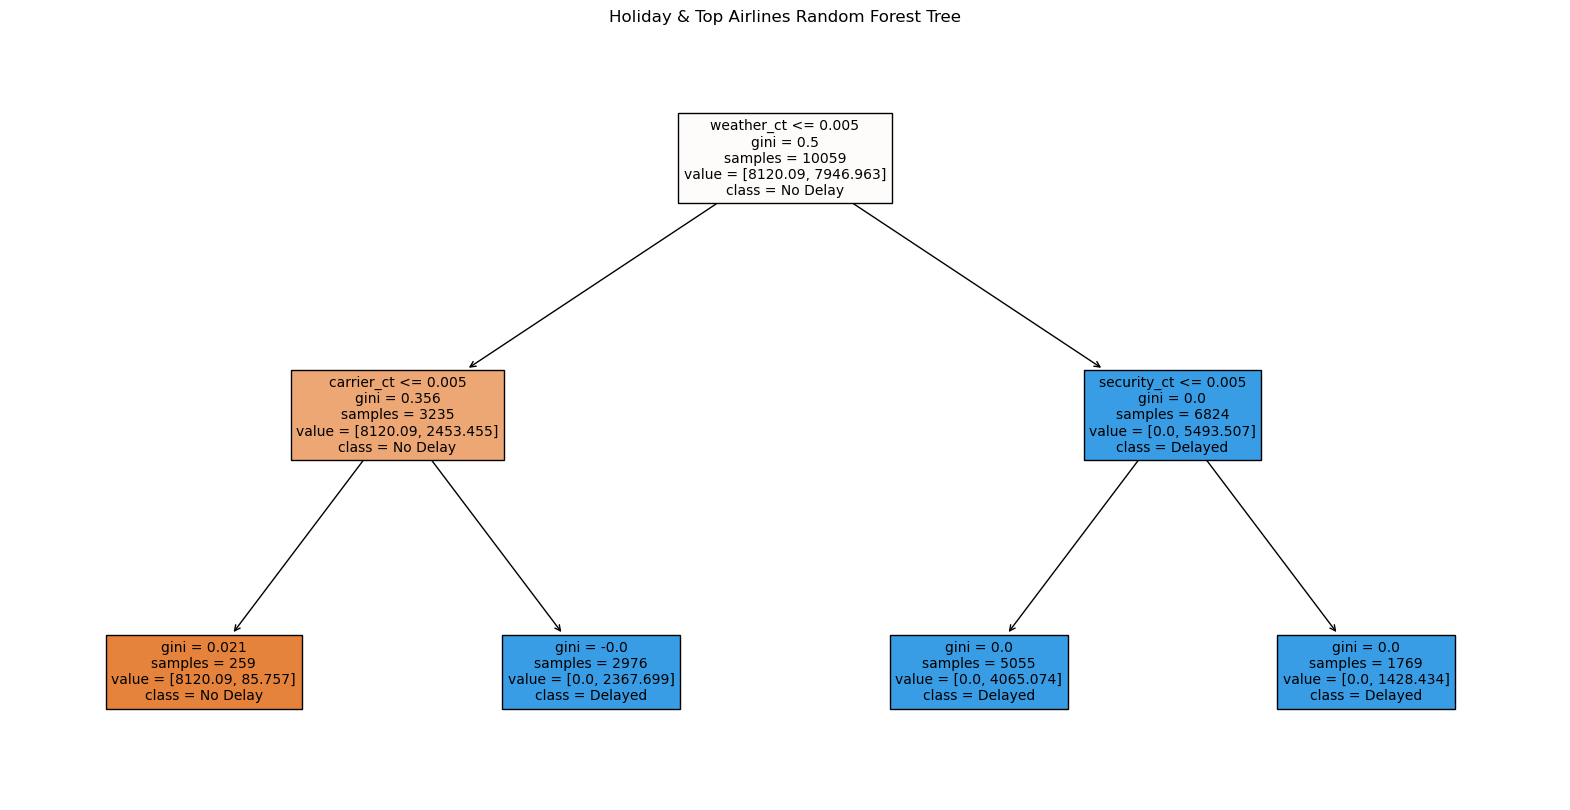

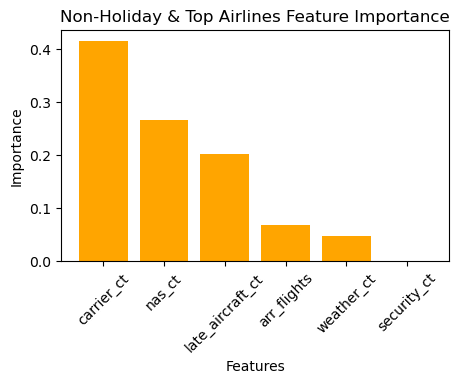

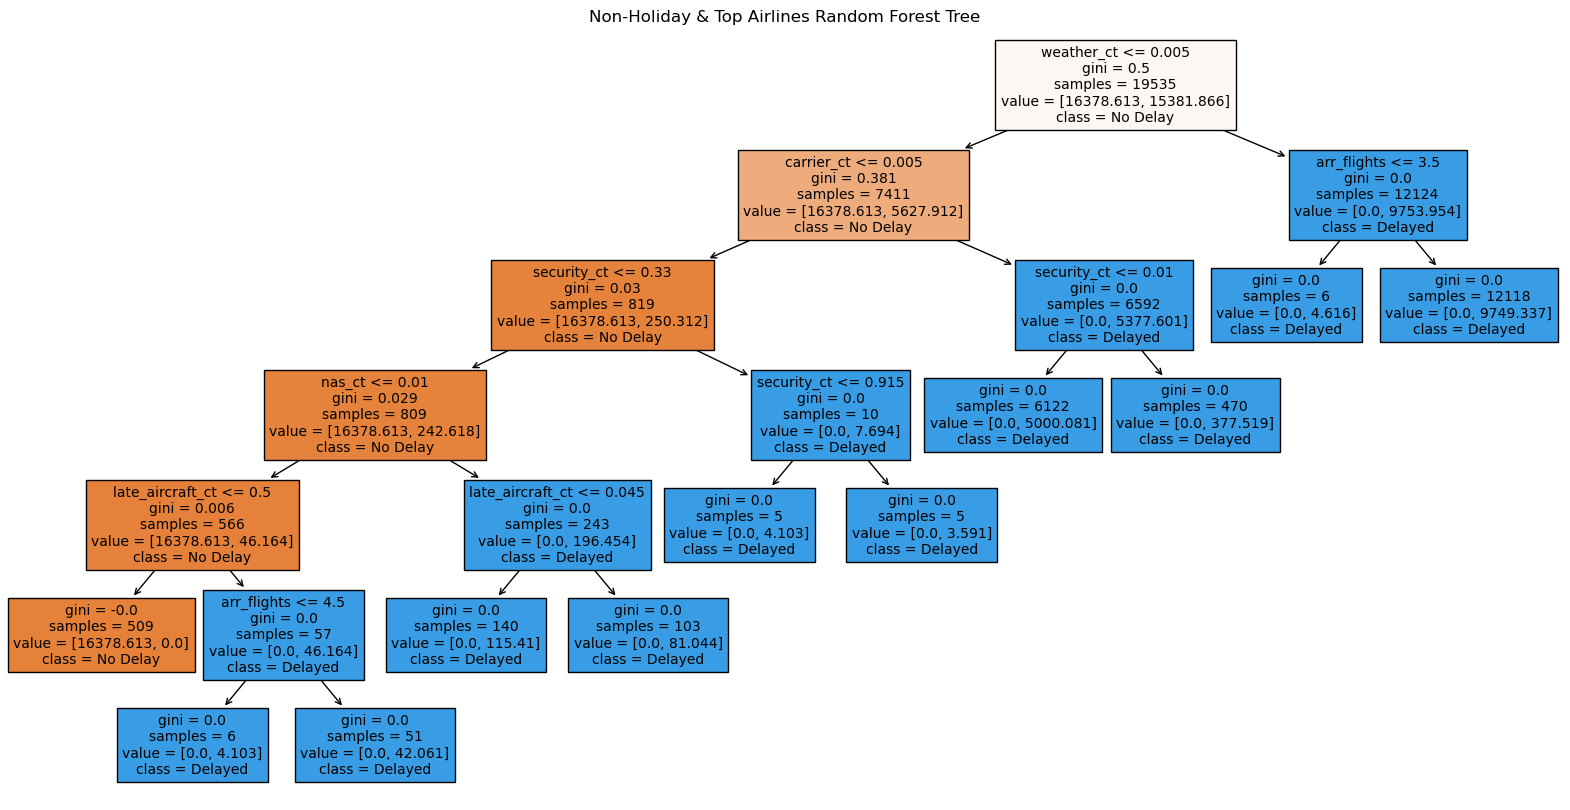

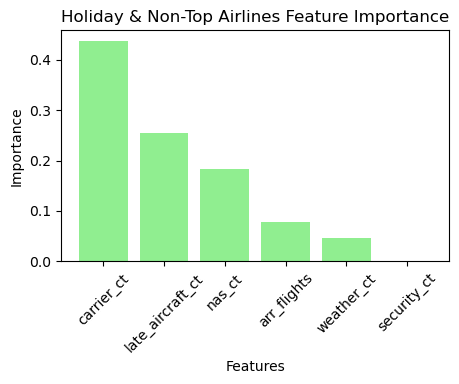

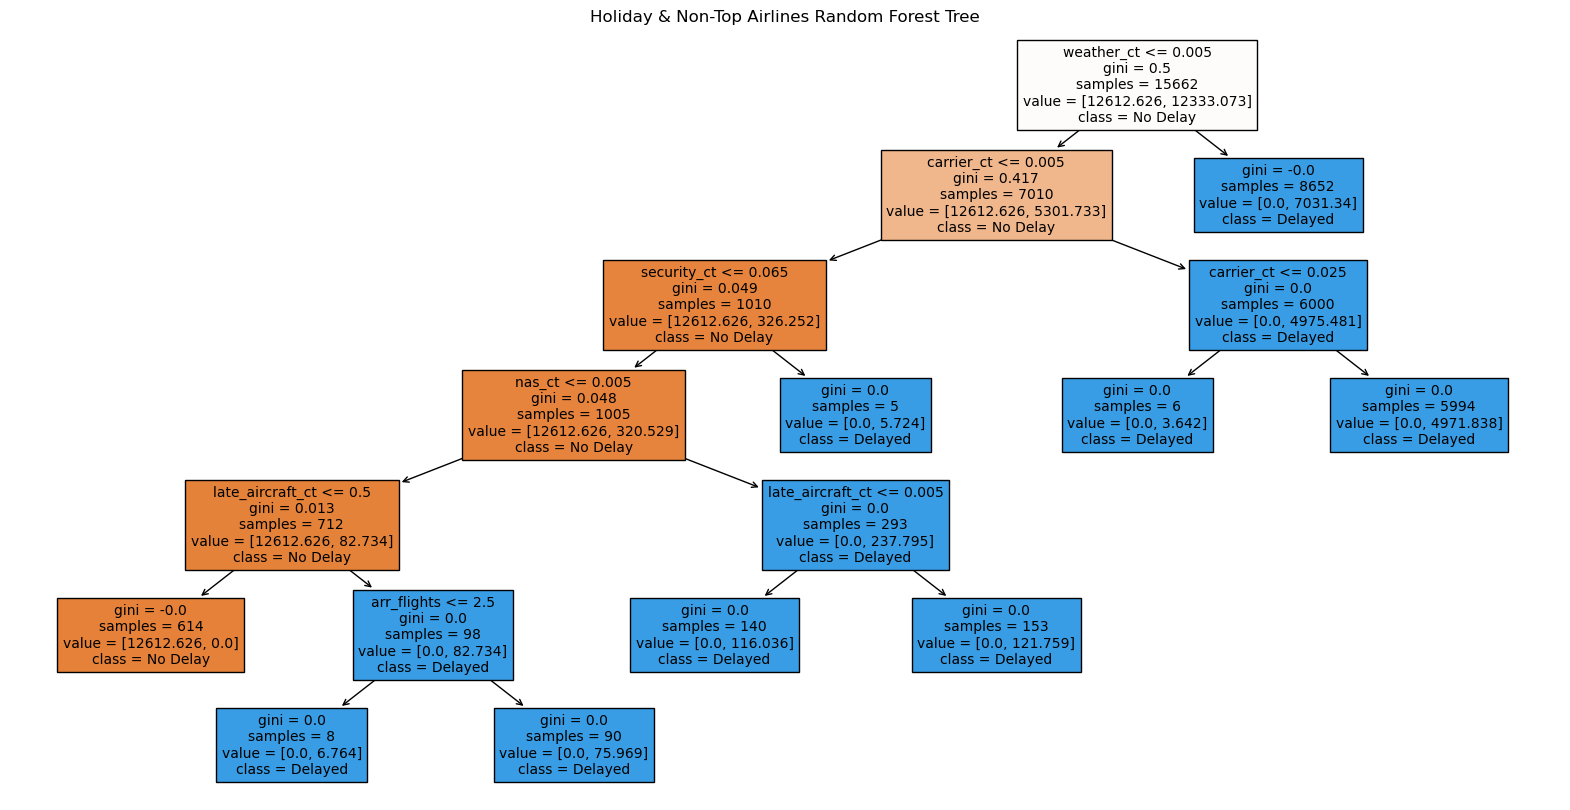

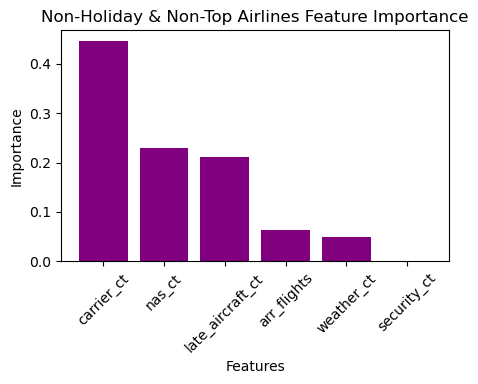

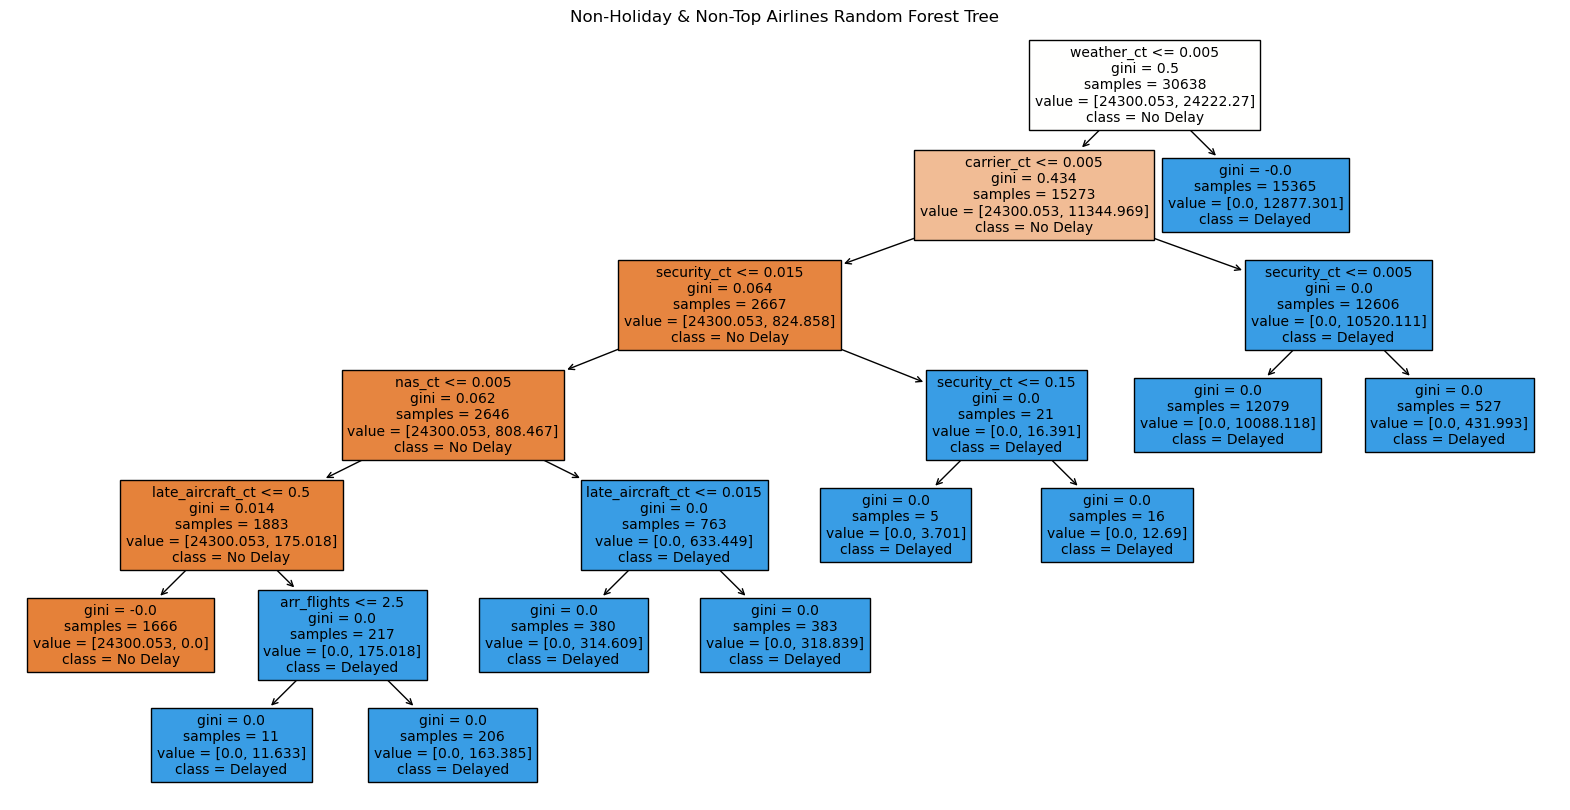

In [32]:
def plot_feature_importance(feature_importances, title, color):
    plt.figure(figsize=(5, 3))
    plt.bar(feature_importances['feature'], feature_importances['importance'], color=color)
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.show()

colors = {
    "holiday_top": "skyblue",
    "non_holiday_top": "orange",
    "holiday_non_top": "lightgreen",
    "non_holiday_non_top": "purple"
}

def plot_rf_tree(model, predictors, title):
    plt.figure(figsize=(20, 10))
    plot_tree(
        model.estimators_[0],
        feature_names=predictors,
        class_names=["No Delay", "Delayed"],
        filled=True,
        fontsize=10
    )
    plt.title(title)
    plt.show()

plot_feature_importance(holiday_top_importances, "Holiday & Top Airlines Feature Importance", colors["holiday_top"])
plot_rf_tree(holiday_top_model, predictors, "Holiday & Top Airlines Random Forest Tree")

plot_feature_importance(non_holiday_top_importances, "Non-Holiday & Top Airlines Feature Importance", colors["non_holiday_top"])
plot_rf_tree(non_holiday_top_model, predictors, "Non-Holiday & Top Airlines Random Forest Tree")

plot_feature_importance(holiday_non_top_importances, "Holiday & Non-Top Airlines Feature Importance", colors["holiday_non_top"])
plot_rf_tree(holiday_non_top_model, predictors, "Holiday & Non-Top Airlines Random Forest Tree")

plot_feature_importance(non_holiday_non_top_importances, "Non-Holiday & Non-Top Airlines Feature Importance", colors["non_holiday_non_top"])
plot_rf_tree(non_holiday_non_top_model, predictors, "Non-Holiday & Non-Top Airlines Random Forest Tree")

In [33]:
print("Accuracy Scores:")
print(f"Holiday & Top Airlines: {round(holiday_top_accuracy, 2)}")
print(f"Non-Holiday & Top Airlines: {round(non_holiday_top_accuracy, 2)}")
print(f"Holiday & Non-Top Airlines: {round(holiday_non_top_accuracy, 2)}")
print(f"Non-Holiday & Non-Top Airlines: {round(non_holiday_non_top_accuracy, 2)}")

Accuracy Scores:
Holiday & Top Airlines: 1.0
Non-Holiday & Top Airlines: 1.0
Holiday & Non-Top Airlines: 1.0
Non-Holiday & Non-Top Airlines: 1.0
